In [1]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
from torch import tensor
import matplotlib.pyplot as plt

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

## Loading our data

In [2]:
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/Users/timothy/.fastai/data/mnist.pkl.gz')

In [3]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), x) = pickle.load(f, encoding='latin-1')

These are all simply large arrays.

Below, `torch.as_tensor` rather than simply `tensor` avoids a warning.

In [4]:
x_train, y_train, x_valid, y_valid = map(torch.as_tensor, (x_train, y_train, x_valid, y_valid))

In [5]:
assert x_train.shape[0] == y_train.shape[0] == 50000 # rows are equal
assert x_train.shape[1] == 28 * 28   # columns, number of pixels in MNIST
assert y_train.min() == 0
assert y_train.max() == 9

In [32]:
mpl.rcParams['image.cmap'] = 'gray'

In [50]:
img = x_train[0]
img.shape

torch.Size([784])

In [47]:
img.view(28, 28).type()

'torch.FloatTensor'

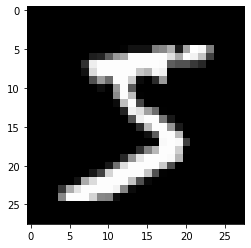

In [51]:
plt.imshow(img.view((28, 28)))

That was how we plotted an image. Note that `img.view` appears to be reshaping the rank 1 tensor.

Now we want to create a simple linear model, y = ax + b

### Creating our model and matrix multplication

In [6]:
weights = torch.randn(784, 10)
weights

tensor([[ 0.0638, -1.4183,  1.4135,  ..., -0.6209,  0.2596, -0.8756],
        [-0.5645,  0.5451, -0.1635,  ...,  2.0907, -0.3679, -0.6033],
        [-2.1198, -0.0117,  1.2902,  ...,  0.2777, -0.9324, -0.7789],
        ...,
        [-0.3277,  1.5207,  0.5813,  ..., -0.3944,  0.7419, -1.2384],
        [ 0.9185, -0.8207,  0.4686,  ..., -0.7112,  0.2668,  0.3567],
        [-1.0438, -1.5868, -0.7236,  ..., -0.3095,  0.5340,  1.4027]])

In [10]:
bias = torch.zeros(10)

784 rows to match the 784 columns in our training dataset. Each image is represented as a rank 1 tensor, 28 * 28 pixels. We can do a matrix multiplication. The 10 is arbitrary, but bias must match.

In [168]:
def matmul(a, b):
    a_rows, a_cols = a.shape
    b_rows, b_cols = b.shape 
    assert a_cols == b_rows
    result_matrix = torch.zeros(a_rows, b_cols)
    for i in range(a_rows):
        for j in range(b_cols):
            for k in range(a_cols): # or b_rows
                result_matrix[i, j] += a[i, k] * b[k, j]
    return result_matrix

This is a lot of fun. We have to iterate over each row of `a`, and each col of `b`. The `k` then moves a pointer across each row and column simultaneously to do the element-wise multiplication. Best visualized along with matrixmultiplication.xyz

In [7]:
m1 = x_valid[:5]
m2 = weights

m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [169]:
%time t1 = matmul(m1, m2)

CPU times: user 793 ms, sys: 3.05 ms, total: 796 ms
Wall time: 798 ms


In [71]:
t1.shape

torch.Size([5, 10])

781 ms is almost a second, and 5 rows / 50000 in x_train means we will take 10000 seconds or 2.77 hours to do a single matrix multiplication across out entire dataset!

Every layer for every pass? Not going to work! Python is thousands of times too slow!

We will rewrite `matmul` to pass to PyTorch.

### Element-wise operations

In [74]:
# element-wise operations
a = tensor([10, .6, -4])
b = tensor([2., 8, 7])
a, b

(tensor([10.0000,  0.6000, -4.0000]), tensor([2., 8., 7.]))

In [76]:
a + b, (a < b).float().mean()

(tensor([12.0000,  8.6000,  3.0000]), tensor(0.6667))

In [78]:
# element-wise on a matrix
m = tensor([[1., 2, 3], [4, 5, 6], [7, 8, 9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Copy and paste from wikipedia to get, e.g.:

$$\|A\|_\text{F} = \sqrt{\sum_{i=1}^m \sum_{j=1}^n |a_{ij}|^2} = \sqrt{\operatorname{trace}\left(A^* A\right)} = \sqrt{\sum_{i=1}^{\min\{m, n\}} \sigma_i^2(A)},$$

And we can translate this equation into code. How much easier!

In [79]:
# this is just
(m * m).sum().sqrt()

tensor(16.8819)

In [85]:
# element-wise
def matmul(a, b):
    a_rows, a_cols = a.shape
    b_rows, b_cols = b.shape 
    assert a_cols == b_rows
    result_matrix = torch.zeros(a_rows, b_cols)
    for i in range(a_rows):
        for j in range(b_cols):
        #    for k in range(a_cols): # or b_rows
         #       result_matrix[i, j] += a[i, k] * b[k, j]
            result_matrix[i, j] = (a[i] * b[:, j]).sum()
    return result_matrix

In [86]:
%time t1 = matmul(m1, m2)

CPU times: user 2.21 ms, sys: 990 µs, total: 3.2 ms
Wall time: 2.28 ms


In [87]:
%timeit -n 10 _=matmul(m1, m2)

1.18 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We have written Python code that calls C code for us. At 700-800 vs 1.18 ms, this is about 700 times faster!

If you try to run `assert m1 == m2` or something, you get a warning that boolean equality on a tensor with more than 1 item is ambiguous. Hence we must use `torch.allclose`, which optionally takes epsilon tolerance.

In [90]:
torch.allclose(m, tensor([[1., 2, 3], [4, 5, 6], [7, 8, 9]]))

True

In [91]:
torch.allclose(t1, matmul(m1, m2))

True

### Broadcasting

To further improve this, we need to use the most powerful tool in our toolbox to call at C speed, or with PyTorch put our code onto the GPU to run at CUDA speed!

It comes from *A Programming Language* in 1962.

In fact, every time in PyTorch we operate on a vector with a scalar, or a matrix with a vector, we are broadcasting, operating at C speed.

In [95]:
c = tensor([10., 20, 30])
c * 2

tensor([20., 40., 60.])

In [96]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [104]:
m + c, m * c

(tensor([[11., 22., 33.],
         [14., 25., 36.],
         [17., 28., 39.]]),
 tensor([[ 10.,  40.,  90.],
         [ 40., 100., 180.],
         [ 70., 160., 270.]]))

In [102]:
t = c.expand_as(m); t, t.storage()

(tensor([[10., 20., 30.],
         [10., 20., 30.],
         [10., 20., 30.]]),
  10.0
  20.0
  30.0
 [torch.FloatStorage of size 3])

In [103]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

Here we see that broadcasting "expands" `c` to the shape of `m`, but does so in a memory-efficient way. Its size is `3x3`, as it should be, but it takes strides size 0 over rows, and size 1 over columns.

C speed for no additional memory. This kind of thing appears in pretty much every linear algebra library.


How mought we turn it into a column?

In [107]:
c, c.unsqueeze(0), c.unsqueeze(1)

(tensor([10., 20., 30.]),
 tensor([[10., 20., 30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

The latter two are identical, just printed differently, afaict.

In [108]:
c.unsqueeze(0).shape, c.unsqueeze(1).shape

(torch.Size([1, 3]), torch.Size([3, 1]))

No, check it out, they have different shapes - the second is an array of arrays, actually. `unsqueeze(n)` tells it where to put it.

In [112]:
tensor([10, 20., 30, 40]).unsqueeze(-3)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got -3)

In [113]:
c[None, :].shape, c[:, None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

`unsqueeze` is a little clunky, but the `None` trick above does the same thing. We can always skip trailing `:`, and `...` means _'all preceding dimensions`_

In [114]:
c[None].shape, c[..., None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

And add additional dimensions, like chaining `unsqueeze()` calls:

In [115]:
c[None, None], c[None, ..., None]

(tensor([[[10., 20., 30.]]]),
 tensor([[[10.],
          [20.],
          [30.]]]))

We can now do:

In [116]:
c.expand_as(m), c[:, None].expand_as(m)

(tensor([[10., 20., 30.],
         [10., 20., 30.],
         [10., 20., 30.]]),
 tensor([[10., 10., 10.],
         [20., 20., 20.],
         [30., 30., 30.]]))

In [117]:
m + c[:, None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

And now we have the result of broadcasting the vector as a column, rather than as a row. The matrix element-wise addition turns out differently.

Now we can use this to eliminate that final loop!

Remember that in the dot product, we perform element-wise multiplication. Then in each row, we sum, and each sum becomes a new column in our output.

Imagine, then, taking each row of m1, and broadcasting the vector. We'll element-wise multiply, then sum. Each sum is a new column in that row of the output matrix.

Below, we `sum()` over the rows, not the columns.

I am thinking of `result_matrix[i]` as looping over to set each row to the output of the entirety of the operation on the right. Worth noting this is the same as `result_matrix[i, :]` but that adds nothing to my understanding att.

In [173]:
# element-wise
def matmul(a, b):
    a_rows, a_cols = a.shape
    b_rows, b_cols = b.shape 
    assert a_cols == b_rows
    result_matrix = torch.zeros(a_rows, b_cols)
    for i in range(a_rows):
       # for j in range(b_cols):
        #    for k in range(a_cols): # or b_rows
         #       result_matrix[i, j] += a[i, k] * b[k, j]
            # result_matrix[i, j] = (a[i] * b[:, j]).sum()
        result_matrix[i] = (a[0][:, None] * b).sum(dim=0)
    return result_matrix

In [137]:
%timeit -n 10 _=matmul(m1, m2)

249 µs ± 82.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [135]:
m1[0].unsqueeze(-1).shape, m1[0][:, None].shape

(torch.Size([784, 1]), torch.Size([784, 1]))

Holy shit. Our previous test clocked us at 1.18 ms or 1180 µs, and now we're at 250 µs, nearly 5x faster.

In [145]:
m[0][:, None] * m

tensor([[ 1.,  2.,  3.],
        [ 8., 10., 12.],
        [21., 24., 27.]])

In [148]:
(m[0][:, None] * m).sum(dim=1)

tensor([ 6., 30., 72.])

### Broadcasting Rules

Eliminating loops makes for much more comfortable programming. Still, keeping in mind which axes to broadcast on gets complicated in higher dimensions.

Numpy/PyTorch compares shapes element-wise, starting with trailing dimensions and working their way forward. Dimensions are compatible when they are equal, or one is 1.

For example:

Image: 256 x 256 x 3
Scale:  1  x  1  x 3

This works.

In [155]:
c, c[None], c[None].shape

(tensor([10., 20., 30.]), tensor([[10., 20., 30.]]), torch.Size([1, 3]))

In [157]:
c[None], c[None].shape

(tensor([[10., 20., 30.]]), torch.Size([1, 3]))

In [159]:
c[None] * c[:, None], c[:, None] * c[None]

(tensor([[100., 200., 300.],
         [200., 400., 600.],
         [300., 600., 900.]]),
 tensor([[100., 200., 300.],
         [200., 400., 600.],
         [300., 600., 900.]]))

This is not the dot product, it is simply element-wise multiplication.

## Einstein Summation

Popularized by Einstein, as he had to work with higher rank tensors and reduce them in the theory of relativity.

As we saw before, our innermost for-loop was replaced with element-wise multiplication, replacing the `k` with the column.

Einstein summation is a mini-string language. Anyplace the letter is repeated, you do a dot product over that dimension.

You can use it for transpose, diagonalization tracing, batchwise versions of everything, go look it up, tons.

In [12]:
# result_matrix[i, j] += a[i, k] * b[k, j]
# result_matrix[i, j] = (a[i] * b[:, j]).sum()
# [i, j] = i,k * k,j
# i,k * k, j -> i, j
# ik, kj -> ij
def matmul(a, b): return torch.einsum('ik, kj -> ij', a, b)

In [13]:
%timeit -n 10 _=matmul(m1, m2)

The slowest run took 6.19 times longer than the fastest. This could mean that an intermediate result is being cached.
97.4 µs ± 101 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Which is like 2.5 times faster than our previous result. 8000 times faster than our first attempt!

Still, this string language is sad, it's like regex, we should be able to write this as normal Python code.

Halide language, like old-school APL, showed you can in fact do this. Recent compiler research gives us hope that Swift will one day let us do just this.

## pytorch op

In [14]:
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 11.23 times longer than the fastest. This could mean that an intermediate result is being cached.
17.2 µs ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


And this is almost 50,000 times faster than our original triple for-loop!

Why? Our original for-loops ran out of space on the cache, and had to go hit up RAM every time. PyTorch et al push this task off to Basic Linear Algebra Subroutines (BLAS) which break up the matrix into mini-matrices and somehow store it on the cache.

Still, sad that we are limited to pre-defined BLAS operations! TF comprehensions are working on giving us more flexibility.

Broadcasting is more flexible than einstein summation is more flexible than BLAS operations.

In [16]:
# above is same as:
m1 @ m2

## The Forward and Backward Passes

We can use our knowledge of broadcasting to create a normalization function!

Takes a tensor, subtracts the mean, divides by standard deviation.

In [8]:
def normalize(x, m, s): return (x-m)/s

In [9]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

In [10]:
x_train = normalize(x_train, train_mean, train_std)

It's very important to normalize your training and validation sets in the same way. Suppose the validation set had more red than green frogs, but the training set vice versa - normalize them each on their own mean and std, and you'll have different scales.

In [11]:
x_valid = normalize(x_valid, train_mean, train_std)

The average and the standard deviation should now be near 0.

Why the heck should the average be near 0?
Why are different scales such a problem?

In [24]:
assert x_train.mean().abs() < 1e-3
assert x_train.std().abs() < 1e-3

In [12]:
x_train[:5]

tensor([[-0.4244, -0.4244, -0.4244,  ..., -0.4244, -0.4244, -0.4244],
        [-0.4244, -0.4244, -0.4244,  ..., -0.4244, -0.4244, -0.4244],
        [-0.4244, -0.4244, -0.4244,  ..., -0.4244, -0.4244, -0.4244],
        [-0.4244, -0.4244, -0.4244,  ..., -0.4244, -0.4244, -0.4244],
        [-0.4244, -0.4244, -0.4244,  ..., -0.4244, -0.4244, -0.4244]])

In [13]:
# the digits will be one of 0-9, so the max is 9
y_train.max()

tensor(9)

In [14]:
n, m = x_train.shape
c = y_train.max() + 1. # we're going to have 10 classes
n, m, c

(50000, 784, tensor(10.))